<a href="https://colab.research.google.com/github/Nhung-Nguyen86/DataScience/blob/main/LSTM_model_to_forecast_river_discharge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Develop an LSTM model to forecast river discharge, precipitation. This model reduces validation loss and training loss by 98%.

import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv('Final_Data_revised.csv')


In [ ]:
pip install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/13/85/6c1092d4b06c3db1ed23d4106488750917156af0b24ab0a2d9951830b0e9/torch-2.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/cf/8f9305cc0ea26badbbb3558ecae54c04a245429f03168f7fad502f8a5b25/torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/9e/1d/1fa4f69e4cd8c83831c3baad0ac9b56ece8ce0e75e5e5c0cdd3f591a458c/torchaudio-2.7.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB 18.4 MB/s eta 0:00:12
   --------

Epoch 0, Train Loss: 0.0123, Val Loss: 0.0064
Epoch 10, Train Loss: 0.0005, Val Loss: 0.0026
Epoch 20, Train Loss: 0.0004, Val Loss: 0.0006
Epoch 30, Train Loss: 0.0004, Val Loss: 0.0008
Epoch 40, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 50, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 60, Train Loss: 0.0003, Val Loss: 0.0004
Epoch 70, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 80, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 90, Train Loss: 0.0002, Val Loss: 0.0002


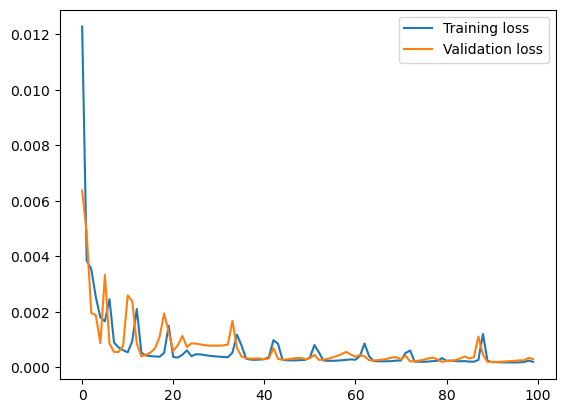

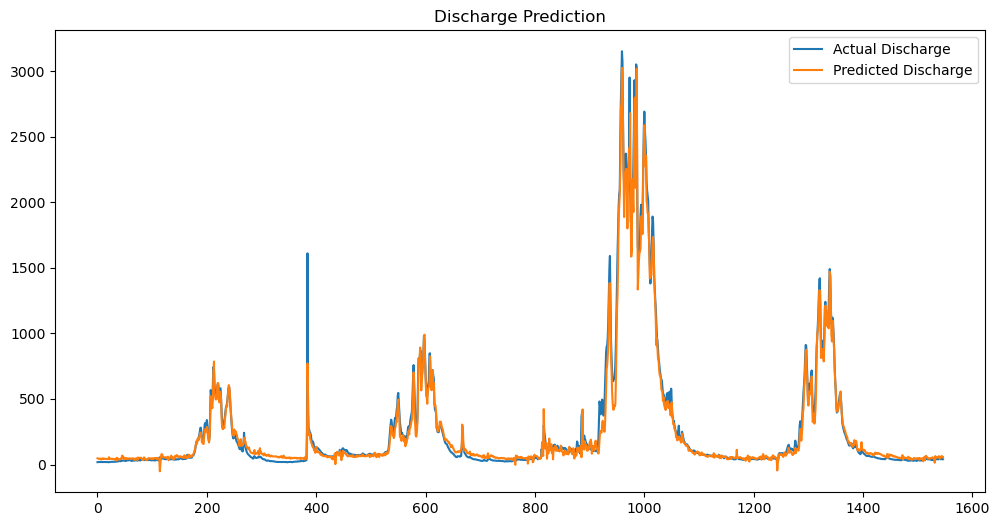

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def prepare_data(df, lookback=30, forecast_horizon=1):
    features = ['mean_SWE', 'Discharge', 'Precipitation', 'tmax', 'tmin',
                'longwave_radiation', 'shortwave_radiation', 'wind', 'hum']
    data = df[features].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - lookback - forecast_horizon):
        X_window = scaled_data[i:(i + lookback), :]
        y_value = scaled_data[i + lookback + forecast_horizon - 1, 1]  # discharge is at index 1
        X.append(X_window)
        y.append(y_value)

    return np.array(X), np.array(y), scaler, features

def inverse_transform_predictions(scaler, predictions, feature_index, feature_names):
    dummy_array = np.zeros((len(predictions), len(feature_names)))
    dummy_array[:, feature_index] = predictions.squeeze()
    return scaler.inverse_transform(dummy_array)[:, feature_index]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()
    return model

def main():
    # Load your data
    # df = pd.read_csv('your_data.csv')

    # Parameters
    lookback = 30
    forecast_horizon = 1
    test_size = 0.2
    batch_size = 32
    hidden_size = 50
    num_layers = 2
    num_epochs = 100
    learning_rate = 0.001

    # Prepare data
    X, y, scaler, feature_names = prepare_data(df, lookback, forecast_horizon)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train).unsqueeze(1)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test).unsqueeze(1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(X_test, y_test)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    input_size = X.shape[2]
    output_size = 1
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Train model
    trained_model = train_model(model, train_loader, val_loader, num_epochs, learning_rate)

    # Evaluate
    trained_model.eval()
    with torch.no_grad():
        test_predictions = trained_model(X_test).numpy()

    # Inverse transform
    test_predictions = inverse_transform_predictions(scaler, test_predictions, 1, feature_names)
    y_test_actual = inverse_transform_predictions(scaler, y_test.numpy(), 1, feature_names)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Discharge')
    plt.plot(test_predictions, label='Predicted Discharge')
    plt.legend()
    plt.title('Discharge Prediction')
    plt.show()

if __name__ == '__main__':
    main()